In [1]:
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
random.seed(10)

In [3]:
class Neuron:
    def __init__(self, id, connected_neurons=None):
        self.__id = id
        self.__output = float(0)
        self.__delta = float(0)
        self.__bias = random.uniform(-0.8, -0.8)

        if connected_neurons is None:
            connected_neurons = []
        self.__connections = {}
        for n in connected_neurons:
            self.__connections[n] = random.uniform(-1.2, 1.2)

    @property
    def output(self):
        return self.__output

    @output.setter
    def output(self, output):
        self.__output = output

    @property
    def delta(self):
        return self.__delta

    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    @property
    def connections(self):
        return self.__connections

    @connections.setter
    def connections(self, connections):
        self.__connections = connections

    @property
    def bias(self):
        return self.__bias

    @bias.setter
    def bias(self, bias):
        self.__bias = bias

    def __hash__(self):
        return hash(self.__id)

In [4]:
import math
import random


class Sigmoid:
    def __init__(self, a):
        self.a = a

    def apply(self, x: float):
        return 1 / (1 + math.exp((-x) * self.a))

    def apply_derivative(self, x: float):
        temp = self.apply(x)
        return self.a * temp * (1 - temp)


class Softsign:
    def __init__(self, a):
        self.a = a

    def apply(self, x: float):
        return x / (1 + abs(x))

    def apply_derivative(self, x: float):
        return 1 / (1 + abs(x)) ** 2


class LeakyReLU:
    def __init__(self, a):
        self.a = a

    def apply(self, x: float):
        return self.a * x if x < 0 else x

    def apply_derivative(self, x: float):
        return self.a if x < 0 else 1

In [5]:
class Layer:
    def __init__(self, neurons: [Neuron]):
        self.__neurons = neurons

    @property
    def neurons(self):
        return self.__neurons

    @neurons.setter
    def neurons(self, neurons):
        self.__neurons = neurons


class ActiveLayer(Layer):
    def __init__(self, neurons: [Neuron], activation_func='sigmoid', a=0.1):
        super(ActiveLayer, self).__init__(neurons)

        if activation_func == 'sigmoid':
            self.__activation_func = Sigmoid(a)
        elif activation_func == 'softsign':
            self.__activation_func = Softsign(a)
        elif activation_func == 'LeakyReLU':
            self.__activation_func = LeakyReLU(a)
        else:
            raise ValueError(f'Unknown function ${activation_func}')

    def apply_func(self, x):
        return self.__activation_func.apply(x)

    def apply_derivative_func(self, neuron):
        return self.__activation_func.apply_derivative(neuron.output)

In [6]:
class Perceptron:
    def __init__(self,
                 layers_params=None,
                 rate=0.1,
                 batch_size=50,
                 epoch_count=10,
                 activation_func='sigmoid',
                 a=1):
        if layers_params is None:
            layers_params = [1, 1]

        self.__rate = rate
        self.__batch_size = batch_size
        self.__epoch_count = epoch_count
        self.__activation_func = activation_func
        self.__a = a
        self.__layers_params = layers_params

        self.__train_avg_error = 0
        self.__res = []
        self.__create_layers(layers_params)

    def get_params(self, deep=True):
        return {
            "layers_params": self.__layers_params,
            "rate": self.__rate,
            "batch_size": self.__batch_size,
            "epoch_count": self.__epoch_count,
            "activation_func": self.__activation_func,
            "a": self.__a
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def __create_layers(self, layers_params):
        n_seq = 0
        input_neuron = Neuron(n_seq)
        layers = [Layer([input_neuron])]
        n_seq += 1

        prev_neurons = [input_neuron]
        neurons = []

        for p in layers_params:
            for j in range(p):
                neurons.append(Neuron(n_seq, prev_neurons))
                n_seq += 1
            layers.append(ActiveLayer(neurons, activation_func=self.__activation_func, a=self.__a))
            prev_neurons = neurons
            neurons = []

        layers.append(ActiveLayer([Neuron(n_seq, prev_neurons)], activation_func=self.__activation_func, a=self.__a))

        self.__layers = layers

    def fit(self, input_values: [[float]], output_values: [[float]]):
        for i in range(self.__epoch_count):
            indices = random.sample(range(len(input_values)), self.__batch_size)

            error = 0
            for iv, ov in zip([input_values[i] for i in indices], [output_values[i] for i in indices]):
                e = self.__train_example(iv, ov)
                error += e
            self.__train_avg_error += error / self.__batch_size

        self.__train_avg_error /= self.__epoch_count

    def predict(self, input_values: [[float]]):
        self.__res = []
        for iv in input_values:
            self.__set_input_layer_values(iv)
            self.__forward_propagate()
            self.__res.append([n.output for n in self.__layers[len(self.__layers) - 1].neurons])
        return self.__res

    def __train_example(self, input_value: [float], output_value: [float]):
        self.__set_input_layer_values(input_value)
        self.__forward_propagate()
        self.__backward_propagate(output_value)
        return self.__calc_error(output_value)

    def __set_input_layer_values(self, input_value):
        __input_layer = self.__layers[0]
        for i in range(len(__input_layer.neurons)):
            __input_layer.neurons[i].output = input_value[i]

    def __forward_propagate(self):
        for i in range(1, len(self.__layers)):
            for n in self.__layers[i].neurons:
                output = n.bias

                for connected_neuron, v in n.connections.items():
                    output += connected_neuron.output * v

                if i == len(self.__layers) - 1:
                    n.output = output
                else:
                    n.output = self.__layers[i].apply_func(output)

        return

    def __backward_propagate(self, output_value: [float]):
        for i in reversed(range(1, len(self.__layers))):
            cur_layer = self.__layers[i]

            if i == len(self.__layers) - 1:
                for n, o in zip(cur_layer.neurons, output_value):
                    n.delta = (n.output - o)
            else:
                for n in cur_layer.neurons:
                    correction = 0
                    for pn in self.__layers[i + 1].neurons:
                        correction += pn.delta * pn.connections[n]
                    n.delta = cur_layer.apply_derivative_func(n) * correction

        for i in range(1, len(self.__layers)):
            cur_layer = self.__layers[i]
            for n in cur_layer.neurons:
                n.bias -= self.__rate * n.delta
                for connected_neuron, v in n.connections.items():
                    n.connections[connected_neuron] -= self.__rate * connected_neuron.output * n.delta

        return

    def __calc_correction(self, i, n):
        correction = 0
        for pn in self.__layers[i - 1].neurons:
            correction += pn.delta * n.connections[pn]
        return correction

    def __calc_error(self, output_value: [float]):
        res = 0
        for n, o in zip(self.__layers[len(self.__layers) - 1].neurons, output_value):
            res += (o - n.output) ** 2
        return res / 2

In [7]:
def get_func_value(func, x):
    if func == 'cos':
        return np.cos(2 * np.pi * x)
    if func == 'poly':
        return 5 * x ** 3 + x ** 2 + 5
    if func == 'sin':
        return x * np.sin(2 * np.pi * x)
    if func == 'x':
        return x

    raise ValueError(f'Unknown function ${func}')

In [8]:
def get_normal_noised_func_value(f, x, mean=0, sd=1):
    f = get_func_value(f, x)
    noise = np.random.normal(mean, sd, f.shape)
    return f, f + noise

In [9]:
def get_layers_params():
    p_1 = []
    for i in range(1, 4):
        p_1.append([i])

    p_2 = []
    for p in p_1:
        for i in range(1, 4):
            p_2.append([p[0], i])

    p__ = p_1 + p_2
    return p__

In [10]:
count = 100
x = np.linspace(0, 1, num=count)

model = Perceptron(
    activation_func='sigmoid',
    rate=0.1,
    layers_params=[3],
    epoch_count=100,
    batch_size=50
)

y, y_noised = get_normal_noised_func_value('poly', x, 0, 0.1)
model.fit([[v] for v in x], [[v] for v in y_noised])
res = model.predict([[v] for v in x])

y_pred = [[v][0] for v in res]

plt.plot(x, y_pred, label='predicted', color="red", marker='x')
plt.plot(x, y_noised, label='noised', color="blue", marker='x')

In [11]:
params = {
    "activation_func": ['sigmoid', 'LeakyReLU'],
    "layers_params": get_layers_params(),
    "rate": np.linspace(0.1, 1, 5, endpoint=True),
    "batch_size": [5, 10, 20],
    "epoch_count": [50, 100, 250, 500],
    "a": np.linspace(0.01, 0.5, 5, endpoint=True)
}

my_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Полином. Кросс-валидация

In [12]:
from sklearn.model_selection import KFold

y, y_noised = get_normal_noised_func_value('poly', x, 0, 0.1)

cv = KFold(n_splits=2, shuffle=True)
search = GridSearchCV(Perceptron(), params, verbose=1, cv=cv, scoring=my_scorer, refit=True)
result = search.fit([[v] for v in x], [[v] for v in y_noised])

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

display(pd.DataFrame(result.cv_results_).sort_values(by='rank_test_score').head(10))

Fitting 2 folds for each of 7200 candidates, totalling 14400 fits
Best Score: -0.22315537200355895
Best Hyperparameters: {'a': 0.3775, 'activation_func': 'sigmoid', 'batch_size': 5, 'epoch_count': 100, 'layers_params': [2, 2], 'rate': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_a,param_activation_func,param_batch_size,param_epoch_count,param_layers_params,param_rate,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
4415,0.007105,0.000080,0.000481,0.000031,0.3775,sigmoid,5,100,"[2, 2]",0.1,"{'a': 0.3775, 'activation_func': 'sigmoid', 'b...",-0.379151,-0.067160,-0.223155,0.155995,1
1706,0.007029,0.000307,0.000484,0.000034,0.1325,sigmoid,10,50,"[1, 3]",0.325,"{'a': 0.1325, 'activation_func': 'sigmoid', 'b...",-0.359703,-0.097161,-0.228432,0.131271,2
2176,0.008446,0.000291,0.000584,0.000034,0.1325,LeakyReLU,5,50,"[1, 1]",0.325,"{'a': 0.1325, 'activation_func': 'LeakyReLU', ...",-0.356375,-0.111837,-0.234106,0.122269,3
4445,0.007125,0.000239,0.000499,0.000015,0.3775,sigmoid,5,250,[2],0.1,"{'a': 0.3775, 'activation_func': 'sigmoid', 'b...",-0.338494,-0.192253,-0.265373,0.073121,4
1284,0.006541,0.000005,0.000404,0.000049,0.01,LeakyReLU,20,100,"[1, 2]",1.0,"{'a': 0.01, 'activation_func': 'LeakyReLU', 'b...",-0.293090,-0.263391,-0.278241,0.014849,5
1753,0.007071,0.000086,0.000479,0.000014,0.1325,sigmoid,10,100,[3],0.775,"{'a': 0.1325, 'activation_func': 'sigmoid', 'b...",-0.360098,-0.223823,-0.291961,0.068137,6
5886,0.006783,0.000088,0.000445,0.000001,0.5,sigmoid,5,250,[2],0.325,"{'a': 0.5, 'activation_func': 'sigmoid', 'batc...",-0.422720,-0.169523,-0.296121,0.126599,7
328,0.006628,0.000027,0.000339,0.000007,0.01,sigmoid,10,100,"[1, 3]",0.775,"{'a': 0.01, 'activation_func': 'sigmoid', 'bat...",-0.404679,-0.188302,-0.296490,0.108188,8
2185,0.006760,0.000065,0.000456,0.000007,0.1325,LeakyReLU,5,50,"[1, 3]",0.1,"{'a': 0.1325, 'activation_func': 'LeakyReLU', ...",-0.487002,-0.114563,-0.300782,0.186219,9
7167,0.006621,0.000002,0.000367,0.000021,0.5,LeakyReLU,20,500,"[1, 3]",0.55,"{'a': 0.5, 'activation_func': 'LeakyReLU', 'ba...",-0.491972,-0.110459,-0.301215,0.190757,10


MSE 0.4448076376631689


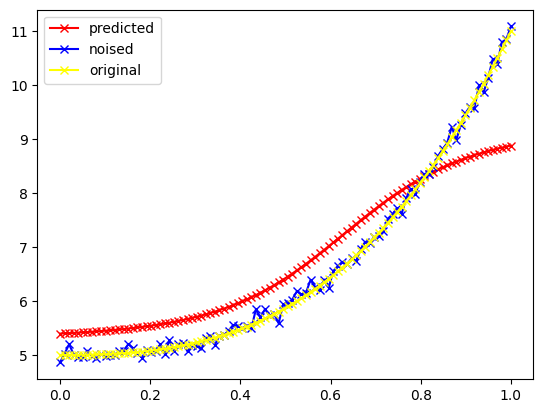

In [13]:
model = search.best_estimator_

res = model.predict([[v] for v in x])
y_pred = [[v][0] for v in res]

plt.plot(x, y_pred, label='predicted', color="red", marker='x')
plt.plot(x, y_noised, label='noised', color="blue", marker='x')
plt.plot(x, y, label='original', color="yellow", marker='x')
plt.legend()

print('MSE ' + str(mean_squared_error(y_noised, y_pred)))

Полином. Ручной подбор

MSE 0.10953062880747526


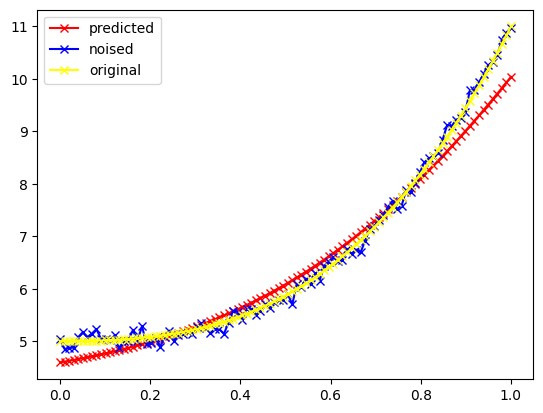

In [14]:
from sklearn.metrics import mean_squared_error

model = Perceptron(
    activation_func='sigmoid',
    rate=0.1,
    layers_params=[3],
    epoch_count=200,
    batch_size=50
)

y, y_noised = get_normal_noised_func_value('poly', x, 0, 0.1)
model.fit([[v] for v in x], [[v] for v in y_noised])
res = model.predict([[v] for v in x])
y_pred = [[v][0] for v in res]

plt.plot(x, y_pred, label='predicted', color="red", marker='x')
plt.plot(x, y_noised, label='noised', color="blue", marker='x')
plt.plot(x, y, label='original', color="yellow", marker='x')
plt.legend()

print('MSE ' + str(mean_squared_error(y_noised, y_pred)))

Синус. Кросс-валидация

In [15]:
y, y_noised = get_normal_noised_func_value('sin', x, 0, 0.1)

cv = KFold(n_splits=2, shuffle=True)
search = GridSearchCV(Perceptron(), params, verbose=1, cv=cv, scoring=my_scorer, refit=True)
result = search.fit([[v] for v in x], [[v] for v in y_noised])

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
display(pd.DataFrame(result.cv_results_).sort_values(by='rank_test_score').head(10))

Fitting 2 folds for each of 7200 candidates, totalling 14400 fits
Best Score: -0.13067022546177645
Best Hyperparameters: {'a': 0.255, 'activation_func': 'sigmoid', 'batch_size': 5, 'epoch_count': 100, 'layers_params': [2, 3], 'rate': 0.775}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_a,param_activation_func,param_batch_size,param_epoch_count,param_layers_params,param_rate,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2983,0.006623,0.000063,0.000396,0.000039,0.255,sigmoid,5,100,"[2, 3]",0.775,"{'a': 0.255, 'activation_func': 'sigmoid', 'ba...",-0.109705,-0.151635,-0.130670,0.020965,1
2541,0.006833,0.000077,0.000434,0.000008,0.1325,LeakyReLU,10,250,"[1, 2]",0.325,"{'a': 0.1325, 'activation_func': 'LeakyReLU', ...",-0.109047,-0.155588,-0.132318,0.023270,2
1008,0.006782,0.000096,0.000427,0.000013,0.01,LeakyReLU,10,50,"[3, 1]",0.775,"{'a': 0.01, 'activation_func': 'LeakyReLU', 'b...",-0.113256,-0.153288,-0.133272,0.020016,3
2949,0.006896,0.000013,0.000384,0.000014,0.255,sigmoid,5,100,[2],1.0,"{'a': 0.255, 'activation_func': 'sigmoid', 'ba...",-0.102185,-0.164776,-0.133480,0.031296,4
6082,0.006840,0.000099,0.000343,0.000006,0.5,sigmoid,10,100,"[1, 2]",0.55,"{'a': 0.5, 'activation_func': 'sigmoid', 'batc...",-0.117081,-0.150095,-0.133588,0.016507,5
1046,0.006662,0.000037,0.000380,0.000019,0.01,LeakyReLU,10,100,"[1, 3]",0.325,"{'a': 0.01, 'activation_func': 'LeakyReLU', 'b...",-0.110188,-0.157456,-0.133822,0.023634,6
4403,0.006750,0.000049,0.000352,0.000005,0.3775,sigmoid,5,100,"[1, 2]",0.775,"{'a': 0.3775, 'activation_func': 'sigmoid', 'b...",-0.111499,-0.156323,-0.133911,0.022412,7
727,0.006845,0.000151,0.000416,0.000067,0.01,LeakyReLU,5,50,[2],0.55,"{'a': 0.01, 'activation_func': 'LeakyReLU', 'b...",-0.106298,-0.161675,-0.133986,0.027688,8
5257,0.006710,0.000019,0.000392,0.000015,0.3775,LeakyReLU,5,500,"[2, 2]",0.55,"{'a': 0.3775, 'activation_func': 'LeakyReLU', ...",-0.103764,-0.164321,-0.134042,0.030278,9
3972,0.006748,0.000136,0.000401,0.000041,0.255,LeakyReLU,10,250,[3],0.55,"{'a': 0.255, 'activation_func': 'LeakyReLU', '...",-0.114269,-0.153840,-0.134055,0.019785,10


MSE 0.1588948836208155


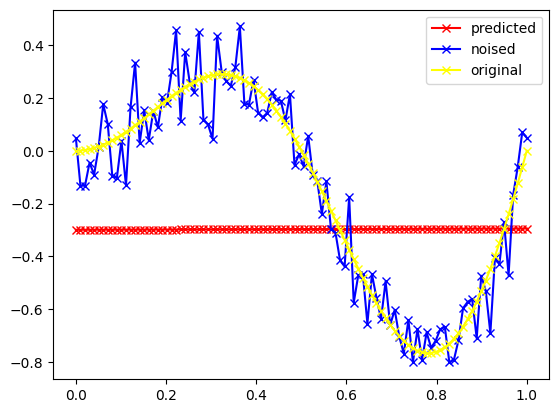

In [16]:
model = search.best_estimator_

res = model.predict([[v] for v in x])
y_pred = [[v][0] for v in res]

plt.plot(x, y_pred, label='predicted', color="red", marker='x')
plt.plot(x, y_noised, label='noised', color="blue", marker='x')
plt.plot(x, y, label='original', color="yellow", marker='x')
plt.legend()

print('MSE ' + str(mean_squared_error(y_noised, y_pred)))

Синус. Ручной подбор

MSE 0.060450879473575775


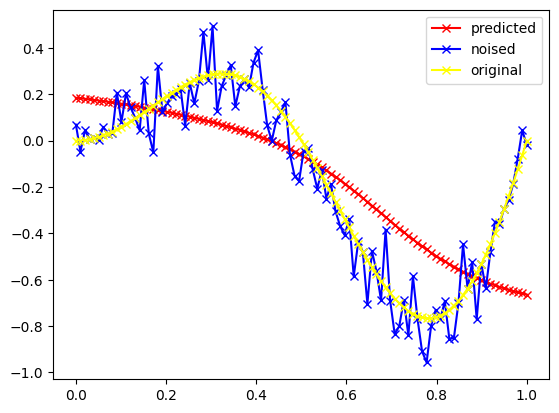

In [17]:
model = Perceptron(
    activation_func='sigmoid',
    rate=0.1,
    layers_params=[2, 2],
    epoch_count=1000,
    batch_size=100
)

y, y_noised = get_normal_noised_func_value('sin', x, 0, 0.1)
model.fit([[v] for v in x], [[v] for v in y_noised])
res = model.predict([[v] for v in x])
y_pred = [[v][0] for v in res]

plt.plot(x, y_pred, label='predicted', color="red", marker='x')
plt.plot(x, y_noised, label='noised', color="blue", marker='x')
plt.plot(x, y, label='original', color="yellow", marker='x')
plt.legend()

print('MSE ' + str(mean_squared_error(y_noised, y_pred)))